In [111]:
cd "/content/drive/MyDrive/Colab Notebooks/dataset"

/content/drive/MyDrive/Colab Notebooks/dataset


In [112]:
%%html
<marquee>
  <div style="width: 100%; color: red; font-size:20px;">
      <div style="width:30%">
          <marquee loop="1" direction="Right" behavior="slide"><u><strong><em>MOVIE RECOMMENDATION SYSTEM</em></strong></u></marquee>
      </div>
  </div>
<marquee>

In [113]:
#Importing libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [114]:
#https://grouplens.org/datasets/movielens/25m/
#Loading Dataset
genomeScores = pd.read_csv("genome-scores.csv")
genomeTags = pd.read_csv("genome-tags.csv")
links = pd.read_csv("links.csv")
movies = pd.read_csv("movies.csv")
rating = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

In [115]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [116]:
#Extracting Genres and store them in a list
#Since set stores values uniquely
genre = set()

for genreString in movies["genres"]:
  for genreElement in genreString.split("|"):
    genre.add(genreElement)

#genre set contains the different genre, now converting it into list
genre = list(genre)

#removing non-genre terms
genre.remove('(no genres listed)')
genre.remove('IMAX')
genre

['Animation',
 'Horror',
 'Western',
 'Drama',
 'Action',
 'Adventure',
 'War',
 'Crime',
 'Mystery',
 'Comedy',
 'Musical',
 'Children',
 'Documentary',
 'Fantasy',
 'Romance',
 'Sci-Fi',
 'Film-Noir',
 'Thriller']

In [117]:
#now adding and altering features that might be of help in the future
movies["year"] = 0

#converting genre column (which contains string) into list and taking year from the title
for x in range(movies["genres"].size):
  try:
    movies["genres"][x] = movies["genres"][x].split("|")
    movies["title"][x] = movies["title"][x].strip()
    movies["year"][x] = int(movies["title"][x][-5:-1])
  except:
    movies["year"][x] = None

In [118]:
movies.sample((10))

,movieId,title,genres,year
37776,153364,Natsamrat (2016),[Drama],2016.0
45198,169834,Men Are From Mars... And That’s Where I’m Goin...,[Comedy],2014.0
17947,93725,"Skin Too Few: The Days of Nick Drake, A (2002)",[Documentary],2002.0
14736,78111,Artists and Models (1955),"[Comedy, Musical]",1955.0
49326,178641,Chasing the Dragon (2017),[(no genres listed)],2017.0
25692,124312,World for Ransom (1954),"[Action, Drama, Thriller]",1954.0
14016,72612,"Fly, The (Légy, A) (1980)","[Animation, Comedy]",1980.0
1806,1895,Can't Hardly Wait (1998),"[Comedy, Drama, Romance]",1998.0
5210,5318,Joshua (2002),[Drama],2002.0
38033,153905,Pokiri (2006),"[Action, Thriller]",2006.0


In [119]:
ploting = movies.groupby("year")["movieId"].count().to_frame(name = 'count')
ploting = ploting.iloc[2:,:]
ploting

,count
year,
1874.0,1
1878.0,1
1880.0,1
1883.0,1
1887.0,1
...,...
2015.0,2513
2016.0,2488
2017.0,2374


Text(0.5, 1.0, 'Movie Count')

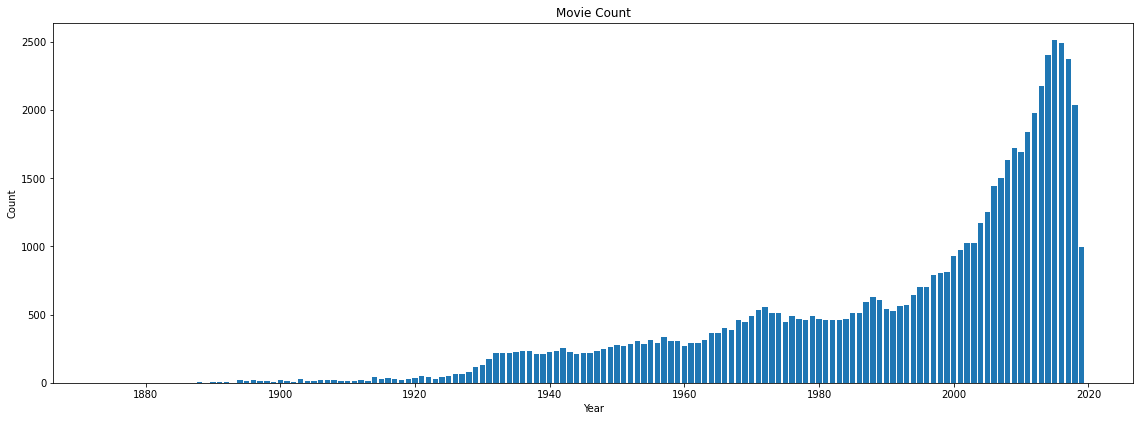

In [120]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ploting.index, ploting["count"], align="center")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movie Count")

In [121]:
genomeScores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [122]:
genomeScores.sort_values("relevance", ascending = False).head()

,movieId,tagId,relevance
3628538,3593,891,1.0
4812000,4734,1081,1.0
2792235,2762,436,1.0
1618582,1610,1031,1.0
1645704,1639,1081,1.0


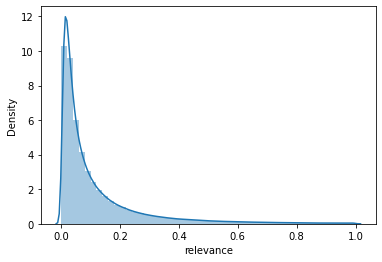

In [123]:
sns.distplot(genomeScores.relevance)

* This plot gives a general idea about the distribution of the 'relevance' feature.

In [124]:
genomeScores[genomeScores["relevance"] == 1].count()

movieId      132
tagId        132
relevance    132
dtype: int64

* Count of the number of the rows where relevance is equal to 1 is 132. As this is a very large number, it is not good for recommendation.
 

In [125]:
#Next dataframe
genomeTags.sample(5)

,tagId,tag
662,663,monster
1026,1027,time loop
596,597,lawyer
686,687,musicians
836,837,rags to riches


* This DataFrame consist of genome tags which together with the relevance might provide a good recommendation, but since text related work is out of scope for now, this part can be listed as a future work for this project.
* Since, I'm not using this dataframe, so I'll drop the tagId feature from genomeScores dataframe

In [126]:
genomeScores.drop("tagId", axis=1, inplace=True)

In [127]:
#Next dataframe
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [128]:
#Next dataframe
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


* userId represents user
* movieId represents movie
* rating represents the score out of 5 by a user to a movie
* Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

Timestamp doesn't seems to give much information, so I'll drop this column.

In [129]:
rating.drop("timestamp", axis=1, inplace=True)

In [130]:
#Next dataframe
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


* tag represents user-generated metadata about movies.

> * Tag data is textual data, since it is out of scope, so I'll not use this dataframe
> * This dataframe can be used for future work.

So, out of six DataFrame, I'll be using the following dataframe:
* movies
* genomeScores
* rating

In [131]:
movies.sample(5)

,movieId,title,genres,year
53510,187567,The Bandit (1953),"[Adventure, Drama]",1953.0
46890,173373,What on Earth! (1966),[Animation],1966.0
49486,178983,Rows (2015),[(no genres listed)],2015.0
9770,32525,The Earrings of Madame de... (1953),"[Drama, Romance]",1953.0
41427,161662,Pufnstuf (1970),"[Children, Comedy, Fantasy]",1970.0


In [132]:
genomeScores.sample(5)

,movieId,relevance
368224,341,0.10100
7454750,7831,0.00750
13961576,134680,0.00425
2008083,2018,0.66400
14610798,161634,0.03750


In [133]:
rating.sample(5)

,userId,movieId,rating
11093329,72177,1265,5.0
18678657,121029,1352,3.0
22427950,145850,2329,3.0
21223430,137904,1682,4.0
18466339,119644,1544,2.0


### Popularity based or Ranking:

IMDb uses the following formula to rank the movies:

> $WR = (v / (v + m) * R) + (m / (v + m) * C)$

here, 
* WR = Weighted Rating
* v = number of votes for the movie
* m = minimum votes required to be listed
* R = average for the movie i.e. mean of ratings
* C = mean vote across whole report

In [134]:
cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [135]:
ls

 2013360_miniprojectreport.gdoc                              popular.ipynb
 2013360_miniprojectvideo.mkv                                popular.py
'6th Sem Mini-Project (Movie Recommendation System).ipynb'   __pycache__/
 dataset/


In [136]:
#importing from the seperate file
from popular import PopularMovies as PM

In [137]:
#calculating 'v' (number of votes for the movies)
movies = PM.noOfVotes(movies, rating)
movies.sample(5)

,movieId,title,genres,year,rating_Count
50655,188261,The Theme (1979),[Drama],1979.0,3
27102,130666,"Little Girl, Big Tease (1976)",[(no genres listed)],1976.0,1
41174,166900,Sondheim! The Birthday Concert (2010),[(no genres listed)],2010.0,1
50301,187513,Coming Home (1998),"[Drama, War]",1998.0,1
16984,89482,Portrait of Maria (María Candelaria (Xochimilc...,"[Drama, Romance]",1944.0,5


In [138]:
#Next, I calculated the 'R' (average for the movie or mean of ratings)
movies = PM.meanRatings(movies, rating)
movies.sample(5)

,movieId,title,genres,year,rating_Count,rating_Average
20450,106082,Shock and Awe: The Story of Electricity (2011),[Documentary],2011.0,11,3.909091
32527,144366,The Twins Effect II (2004),"[Action, Adventure, Comedy, Sci-Fi]",2004.0,15,2.133333
36426,154578,The Revenge of the Living Dead Girls (1987),[Horror],1987.0,3,1.666667
25936,126985,Remonstrance (1972),[(no genres listed)],1972.0,3,2.666667
41792,168332,Falling Cat (1894),[Documentary],1894.0,11,2.909091


In [139]:
C = PM.meanVotes(movies)

In [140]:
m = PM.minVotes(movies)

In [141]:
#making the dataset short based on the 98th quantile
popular_movies = PM.popularMoviesDataFrame(movies, m)
popular_movies.shape

(1181, 6)

In [142]:
def weighted_rating(df, m=m, C=C):
    #All the above functions have to be calculated first.
    v = df["rating_Count"]
    R = df["rating_Average"]
    return (v / (v + m) * R) + (m / (v + m) * C)

# Define a new feature 'ranking' and calculate its value with `weighted_rating()
popular_movies['ranking'] = popular_movies.apply(weighted_rating, axis=1)
popular_movies.sample(5)

,movieId,title,genres,year,rating_Count,rating_Average,ranking
7248,7373,Hellboy (2004),"[Action, Adventure, Fantasy, Horror]",2004.0,9362,3.306879,3.223034
2448,2539,Analyze This (1999),[Comedy],1999.0,9380,3.247335,3.184767
2780,2872,Excalibur (1981),"[Adventure, Fantasy]",1981.0,5883,3.604539,3.355006
504,509,"Piano, The (1993)","[Drama, Romance]",1993.0,15998,3.681116,3.532070
5,6,Heat (1995),"[Action, Crime, Thriller]",1995.0,24588,3.854909,3.718657


> Now, I got the rankings for the movies. After that, sorting based on the rankings and displaying top 10 movies

In [143]:
popular_movies = PM.sortMoviesOnRanking(popular_movies, "ranking")
popular_movies.head(10)

,movieId,title,genres,year,rating_Count,rating_Average,ranking
314,318,"Shawshank Redemption, The (1994)","[Crime, Drama]",1994.0,81482,4.413576,4.333412
840,858,"Godfather, The (1972)","[Crime, Drama]",1972.0,52498,4.324336,4.211894
49,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995.0,55366,4.284353,4.180655
522,527,Schindler's List (1993),"[Drama, War]",1993.0,60411,4.247579,4.154760
2867,2959,Fight Club (1999),"[Action, Crime, Drama, Thriller]",1999.0,58773,4.228311,4.134673
292,296,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",1994.0,79672,4.188912,4.120742
1190,1221,"Godfather: Part II, The (1974)","[Crime, Drama]",1974.0,34188,4.261759,4.105241
2480,2571,"Matrix, The (1999)","[Action, Sci-Fi, Thriller]",1999.0,72674,4.154099,4.082116
585,593,"Silence of the Lambs, The (1991)","[Crime, Horror, Thriller]",1991.0,74127,4.151342,4.080857
1164,1193,One Flew Over the Cuckoo's Nest (1975),[Drama],1975.0,36058,4.218662,4.074652


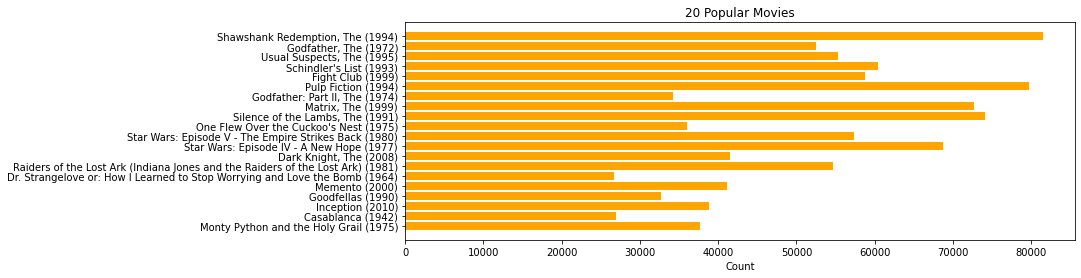

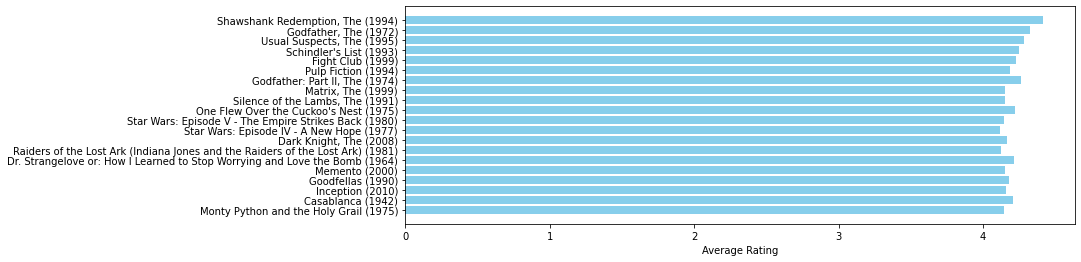

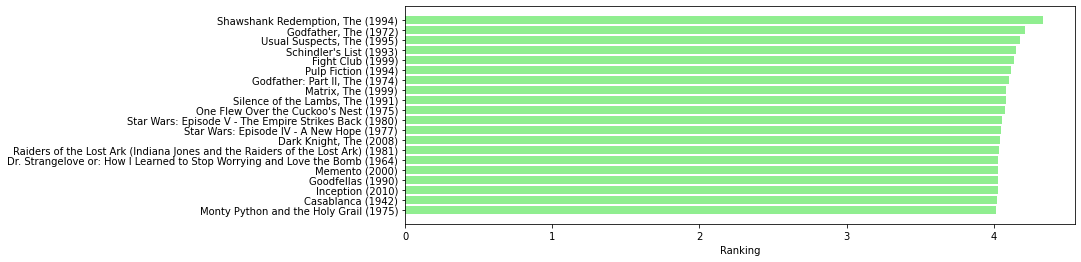

In [144]:
#Lets Visualize the top movies against its ranking
plt.figure(figsize=(12,4))
plt.barh(popular_movies['title'].head(20), popular_movies['rating_Count'].head(20), align='center', color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("20 Popular Movies")
plt.show()

plt.figure(figsize=(12,4))
plt.barh(popular_movies['title'].head(20), popular_movies['rating_Average'].head(20), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Average Rating")
plt.show()

plt.figure(figsize=(12,4))
plt.barh(popular_movies['title'].head(20), popular_movies['ranking'].head(20), align='center', color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Ranking")
plt.show()

In [145]:
ploting1 = popular_movies.groupby("year")["movieId"].count().to_frame(name = "count")

Text(0.5, 1.0, 'Movie Count')

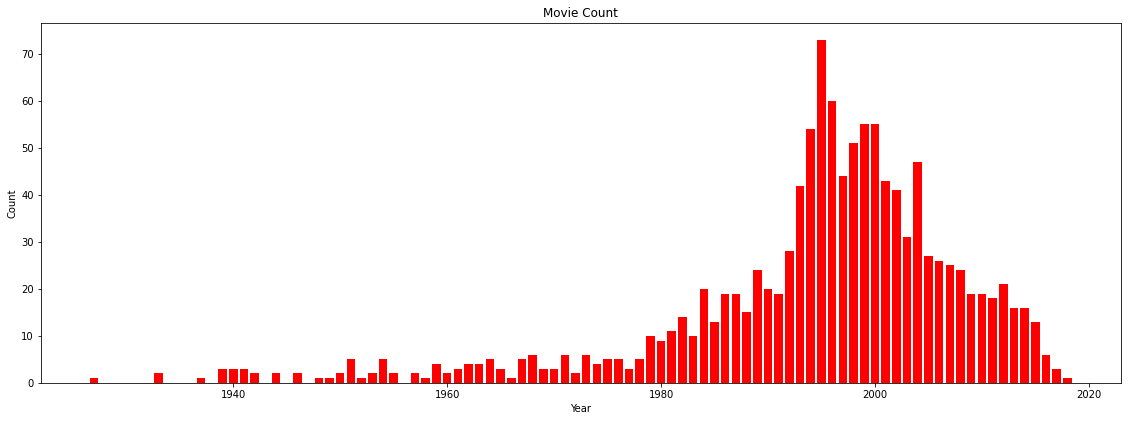

In [146]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ploting1.index, ploting1["count"], align='center', color="red")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movie Count")

> The above result was for the crowd, who are not sure about the genre they are interested in... i.e. A common popularity based recommendation considering all genres.

> Now, I aim to recommend popular movies based on their genres.

In [147]:
#Select the Genre
list1 = []

Action = True #@param {type:"boolean"}
if Action:
  list1.append("Action")
Adventure = False #@param {type:"boolean"}
if Adventure:
  list1.append("Adventure")
Animation = False #@param {type:"boolean"}
if Animation:
  list1.append("Animation")
Children = True #@param {type:"boolean"}
if Children:
  list1.append("Children")
Comedy = False #@param {type:"boolean"}
if Comedy:
  list1.append("Comedy")
Crime = False #@param {type:"boolean"}
if Crime:
  list1.append("Crime")
Documentary = False #@param {type:"boolean"}
if Documentary:
  list1.append("Documentary")
Drama = False #@param {type:"boolean"}
if Drama:
  list1.append("Drama")
Fantasy = True #@param {type:"boolean"}
if Fantasy:
  list1.append("Fantasy")
Film_Noir = False #@param {type:"boolean"}
if Film_Noir:
  list1.append("Film-Noir")
Horror = False #@param {type:"boolean"}
if Horror:
  list1.append("Horror")
Musical = False #@param {type:"boolean"}
if Musical:
  list1.append("Musical")
Mystery = False #@param {type:"boolean"}
if Mystery:
  list1.append("Mystery")
Romance = False #@param {type:"boolean"}
if Romance:
  list1.append("Romance")
Sci_Fi = False #@param {type:"boolean"}
if Sci_Fi:
  list1.append("Sci-Fi")
Thriller = False #@param {type:"boolean"}
if Thriller:
  list1.append("Thriller")
War = False #@param {type:"boolean"}
if War:
  list1.append("War")
Western = False #@param {type:"boolean"}
if Western:
  list1.append("Western")

In [148]:
list1

['Action', 'Children', 'Fantasy']

In [149]:
#generating columns based on genre
genre.sort()
for g in genre:
  movies["%s" %g] = 0

#updating values of features
for x in range(movies["genres"].size):
  for listing in movies["genres"][x]:
    for g in genre:
      if listing == g:
        movies["%s" %g][x] = 1

In [150]:
movies.head()

,movieId,title,genres,year,rating_Count,rating_Average,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,57309,3.893708,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0,24228,3.251527,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995.0,11804,3.142028,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995.0,2523,2.853547,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],1995.0,11714,3.058434,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [151]:
#counting the movies that belongs to a genre
count_genre = []
for g in genre:
  count_genre.append(movies["%s" %g].sum())

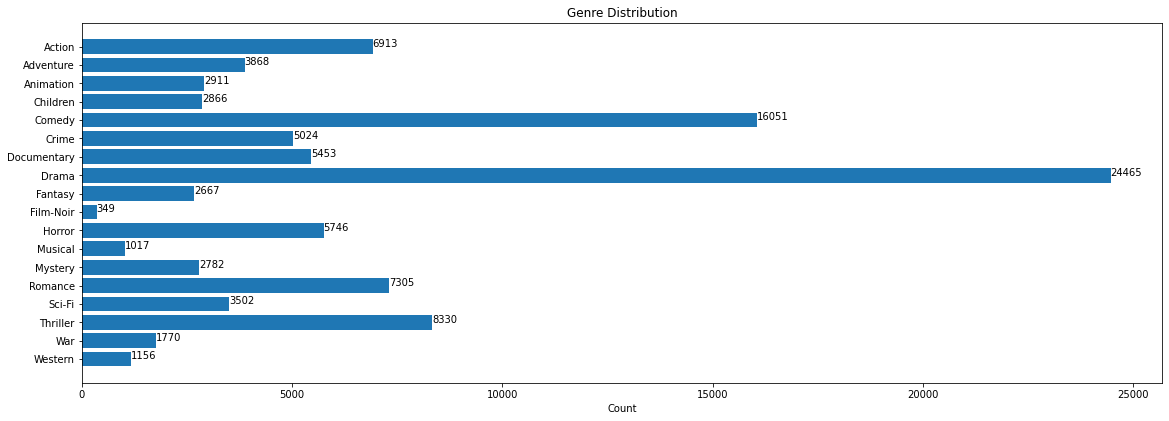

In [152]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.barh(genre, count_genre, align='center')
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Genre Distribution")
for index, value in enumerate(count_genre):
    plt.text(value, index, str(value))

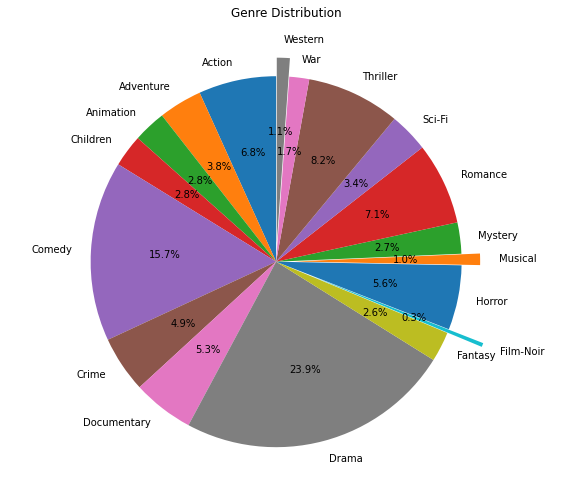

In [153]:
explode = (0,0,0,0,0,0,0,0,0,0.2,0,0.1,0,0,0,0,0,0.1)
plt.figure(figsize=(10,8))
plt.pie(count_genre, labels=genre,
        startangle=90,
        explode = explode,
        autopct = '%1.1f%%')

plt.axis('equal') 
plt.title("Genre Distribution\n")
plt.show()

In [154]:
popMovies = movies
for x in list1:
  popMovies = popMovies[popMovies["%s" %x] == 1]

In [155]:
popMovies.shape

(39, 24)

In [156]:
co = 0.75

if popMovies.shape[0]:
  df = PM.getPopular(popMovies, co)
else:
  df = popular_movies
df.shape

(10, 25)

In [157]:
df.head()

,movieId,title,genres,year,rating_Count,rating_Average,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ranking
6238,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,"[Action, Adventure, Animation, Children, Fanta...",1986.0,5448,4.067640,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,3.806372
1916,2005,"Goonies, The (1985)","[Action, Adventure, Children, Comedy, Fantasy]",1985.0,11854,3.641724,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3.554149
20978,108932,The Lego Movie (2014),"[Action, Adventure, Animation, Children, Comed...",2014.0,6666,3.686919,1,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3.535467
2323,2414,Young Sherlock Holmes (1985),"[Action, Adventure, Children, Fantasy, Mystery...",1985.0,2458,3.371033,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,3.180742
7039,7164,Peter Pan (2003),"[Action, Adventure, Children, Fantasy]",2003.0,1560,3.391667,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.135821


* Now, I'll go for **Content based Recommender**.
* I'll use K-Nearest Neighbour algorithm. 


In [158]:
train = movies.iloc[:, 6:].values
train[0:5]

array([[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [159]:
nbrs = NearestNeighbors(n_neighbors=5).fit(train)

In [160]:
input = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print(nbrs.kneighbors([input]))

(array([[0., 0., 0., 0., 0.]]), array([[    0, 29330, 27319, 10958,  2203]]))


In [161]:
movies.iloc[nbrs.kneighbors([input])[1][0], 1:6]

,title,genres,year,rating_Count,rating_Average
0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,57309,3.893708
29330,Scooby-Doo! Mask of the Blue Falcon (2012),"[Adventure, Animation, Children, Comedy, Fantasy]",2012.0,14,3.285714
27319,Brother Bear 2 (2006),"[Adventure, Animation, Children, Comedy, Fantasy]",2006.0,142,3.278169
10958,"Ant Bully, The (2006)","[Adventure, Animation, Children, Comedy, Fanta...",2006.0,525,2.802857
2203,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",1998.0,10937,3.236308


In [162]:
list1 = []

Action = True #@param {type:"boolean"}
list1.append(int(Action))
Adventure = False #@param {type:"boolean"}
list1.append(int(Adventure))
Animation = False #@param {type:"boolean"}
list1.append(int(Animation))
Children = True #@param {type:"boolean"}
list1.append(int(Children))
Comedy = False #@param {type:"boolean"}
list1.append(int(Comedy))
Crime = False #@param {type:"boolean"}
list1.append(int(Crime))
Documentary = False #@param {type:"boolean"}
list1.append(int(Documentary))
Drama = False #@param {type:"boolean"}
list1.append(int(Drama))
Fantasy = True #@param {type:"boolean"}
list1.append(int(Fantasy))
Film_Noir = False #@param {type:"boolean"}
list1.append(int(Film_Noir))
Horror = False #@param {type:"boolean"}
list1.append(int(Horror))
Musical = False #@param {type:"boolean"}
list1.append(int(Musical))
Mystery = False #@param {type:"boolean"}
list1.append(int(Mystery))
Romance = False #@param {type:"boolean"}
list1.append(int(Romance))
Sci_Fi = False #@param {type:"boolean"}
list1.append(int(Sci_Fi))
Thriller = False #@param {type:"boolean"}
list1.append(int(Thriller))
War = False #@param {type:"boolean"}
list1.append(int(War))
Western = False #@param {type:"boolean"}
list1.append(int(Western))


list1

[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [163]:
def kNN(list1, n=5):
  nbrs = NearestNeighbors(n_neighbors=n).fit(train)
  output = nbrs.kneighbors([list1])
  return output[1][0]
  
output = kNN(list1, 6)
movies.iloc[output, [1,2,4,5]]

,title,genres,rating_Count,rating_Average
3343,Teenage Mutant Ninja Turtles II: The Secret of...,"[Action, Children, Fantasy]",2608,2.518980
11297,Arthur and the Invisibles (2007),"[Action, Children, Fantasy]",434,3.076037
42607,Jason and the Argonauts (2000),"[Action, Children, Fantasy]",3,3.000000
40667,Captain Sindbad (1963),"[Action, Adventure, Children, Fantasy]",4,3.000000
179,Mighty Morphin Power Rangers: The Movie (1995),"[Action, Children]",2539,1.953525
58850,Kadonnut: Joulupukki (2014),"[Children, Fantasy]",2,4.500000
